In [39]:
import tensorflow as tf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
%matplotlib inline
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, GRU, Flatten, LSTM, SimpleRNN

In [2]:
news_data = pd.read_pickle(r"./Datasets/data/financial_headlines_20061020-20131119.pkl")
df = pd.DataFrame(news_data)
df.set_index('date',inplace=True)
financial_data = pd.read_pickle(r"./Datasets/data/stock_data.pkl")
oneyearrate = financial_data['1 YEAR']

In [3]:
start_date = datetime(2006,10,20)
end_date = datetime(2013,1,1)
titles = df.loc[start_date.strftime("%Y-%m-%d") : end_date.strftime("%Y-%m-%d")]

In [73]:
def concat_news(news,period):
    """Merges news headlines over a period of days as one single list of words,
    tokenized by word_tokenize() in nltk. 
    
    Parameters: 
    news (DataFrame): News data of headlines (str) indexed by datetime.   
    period (int): Number of days in each period. 
    
    Returns: 
    DataFrame of lists of words indexed by datetime.
    """
    delta = timedelta(days=period)
    t1 = news.index[0]
    t2 = t1 + delta
    end_date = news.index[-1]
    data = pd.DataFrame({'titles': [], 'date': []})
    while(t2 < end_date):
        period_words = []
        titles = list([word_tokenize(title) for title in news.loc[t1.strftime("%Y-%m-%d") : t2.strftime("%Y-%m-%d")]['title']])
        for title in titles: 
            for word in title: 
                period_words.append(word)
        data = data.append({'date': t1, 'titles': period_words},ignore_index=True)
        t1 = t2
        t2 = t2 + delta    
    titles = list([word_tokenize(t) for t in news.loc[t1.strftime("%Y-%m-%d") : end_date.strftime("%Y-%m-%d")]['title']])
    for title in titles: 
            for word in title: 
                period_words.append(word)
    data = data.append({'date': t1, 'titles': period_words},ignore_index=True)
    data.set_index('date',inplace=True)
    return data
    
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=32):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True: 
        if shuffle: 
            rows = np.random.randint(
            min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index: 
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                       lookback,
                       data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j])
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
    
def add_rate_data(x_words,x_rates,indices):
    """Add time-series data of the rate/returns to a data point which
    containes some vectorized version of words. If the word-data has a datapoint from 
    a day not included in the rate/return-date, an average of the closest datapoints 
    in time are selected. 
    
    Parameters: 
    A numpy array x_words representing the words with shape n*d and a numpy array 
    x_rates of prices/rates with shape n. 
    
    Returns: 
    A numpy array of shape n*(d+1) 
    """
    start_date = x_rates.index[0]
    end_date = x_rates.index[-1]
    temp = np.zeros((x_words.shape[0], x_words.shape[1]+1))
    temp[:,:-1] = x_words
    n_interpol = 0
    for i, date in enumerate(indices): 
        if date not in x_rates: 
            n_interpol += 1
            prev_valid = date
            next_valid = date
            while prev_valid not in x_rates:
                prev_valid = prev_valid - timedelta(days=1)
                if prev_valid < start_date: 
                    prev_valid = start_date
                    break
            while next_valid not in x_rates: 
                next_valid = next_valid + timedelta(days=1)
                if next_valid > end_date: 
                    next_valid = end_date
                    break
            rate = (x_rates.loc[prev_valid] + x_rates.loc[next_valid]) / 2
            temp[i,-1] = rate
        else: 
            temp[i,-1] = x_rates.loc[date]
    print("{} interpolated values of {} total.".format(n_interpol, len(indices)))
    return temp

def plot_history(history,title="",train=True,val=True,log=True):
    if train: 
        plt.plot(history.history['loss'],label="Train")
    if val:
        plt.plot(history.history['val_loss'],label="Val")
    plt.legend()
    if log : plt.yscale('log')
    if not title == "" : plt.title(title)
    plt.show()

def naive_prediction_gen(gen, steps):
    mse = []
    for step in range(steps):
        samples, targets = next(gen)
        preds = samples[:, -1, 1]
        mse.append(np.mean(np.square(preds - targets)))
    return np.mean(mse)
    

In [74]:
# Aggregate the headlines into blocks of x days. 
concated_news = concat_news(titles,1)

In [75]:
# Tokenize the data using tf-idf from Keras and split into train/test
max_words = 1000                # Include the max_words most common words. 
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(concated_news['titles'])
x = tokenizer.texts_to_matrix(concated_news['titles'],mode='tfidf')

# Add a column with the price data
x = add_rate_data(x,oneyearrate,concated_news.index)
n,d = x.shape

648 interpolated values of 2265 total.


In [76]:
# Training for eps epochs
eps = 100
# Create generators 
train_split = 0.6
val_split = 0.2
test_split = 0.2
lookback=30
delay=30
batch_size=10
train_gen = generator(data=x,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=round(train_split*n),
                      shuffle=True,
                      batch_size=batch_size
)

val_gen = generator(data=x,
                    lookback=lookback,
                    delay=delay,
                    min_index=round(train_split*n) + 1,
                    max_index=round(train_split*n) + round(val_split*n),
                    batch_size=batch_size
)

test_gen = generator(data=x,
                     lookback=lookback,
                     delay=delay,
                     min_index=round(train_split*n) + round(val_split*n) + 1,
                     max_index=None,
                    batch_size=batch_size
)

val_steps = (round(val_split*n) - 1 - lookback) // batch_size

test_steps = (n - round(train_split*n) - round(val_split*n) - 1 - lookback) // batch_size

In [77]:
# Create a simple feed-forward model (no recurrent layers)
m_ff = Sequential()
m_ff.add(Flatten(input_shape=(lookback,x.shape[-1])))
m_ff.add(Dense(32,activation='relu'))
m_ff.add(Dense(1))
m_ff.add(Activation('linear'))

m_ff.compile(loss='MSE',optimizer='adam')
m_ff.summary()
batch_size = 32
epochs = 100

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 30030)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)                960992    
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 33        
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 961,025
Trainable params: 961,025
Non-trainable params: 0
_________________________________________________________________


In [78]:
# Create a simple RNN model
m_rnn = Sequential()
m_rnn.add(SimpleRNN(32, return_sequences=True,input_shape=(None, x.shape[-1])))
m_rnn.add(SimpleRNN(32))
m_rnn.add(Dense(1))
m_rnn.compile(optimizer='adam',loss='mse')

m_rnn.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_13 (SimpleRNN)    (None, None, 32)          33088     
_________________________________________________________________
simple_rnn_14 (SimpleRNN)    (None, 32)                2080      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 33        
Total params: 35,201
Trainable params: 35,201
Non-trainable params: 0
_________________________________________________________________


In [79]:
# Create an RNN-model with GRU
m_gru = Sequential() 
m_gru.add(GRU(32,
              dropout=0.2,
              recurrent_dropout=0.2,
              return_sequences=True,
              input_shape=(None, x.shape[-1])))
m_gru.add(GRU(32,
             dropout=0.2,
             recurrent_dropout=0.2))
m_gru.add(Dense(1))

m_gru.compile(optimizer='adam', loss='mse')
m_gru.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, None, 32)          99360     
_________________________________________________________________
gru_8 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 33        
Total params: 105,729
Trainable params: 105,729
Non-trainable params: 0
_________________________________________________________________


In [80]:
# Create an RNN-model with LSTM
m_lstm = Sequential() 
m_lstm.add(LSTM(32,
                dropout=0.2,
                recurrent_dropout=0.2,
                return_sequences=True,
                input_shape=(None, x.shape[-1])))
m_lstm.add(LSTM(32,
                dropout=0.2,
                recurrent_dropout=0.2))
m_lstm.add(Dense(1))
m_lstm.compile(optimizer='adam', loss='mse')
m_lstm.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, None, 32)          132352    
_________________________________________________________________
lstm_20 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 33        
Total params: 140,705
Trainable params: 140,705
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit feed-forward model 
ff_history = m_ff.fit_generator(train_gen,
                               steps_per_epoch=10,
                               epochs=500,
                               validation_data=val_gen,
                               validation_steps=val_steps)

Epoch 1/500
10/10 [==============================] - 1s 60ms/step - loss: 3.0876 - val_loss: 4.3292
Epoch 2/500
10/10 [==============================] - 1s 61ms/step - loss: 3.1428 - val_loss: 4.2973
Epoch 3/500
10/10 [==============================] - 1s 60ms/step - loss: 3.2048 - val_loss: 4.2660
Epoch 4/500
10/10 [==============================] - 1s 59ms/step - loss: 3.5223 - val_loss: 4.2337
Epoch 5/500
10/10 [==============================] - 1s 62ms/step - loss: 3.2368 - val_loss: 4.2013
Epoch 6/500
10/10 [==============================] - 1s 61ms/step - loss: 3.2409 - val_loss: 4.1689
Epoch 7/500
10/10 [==============================] - 1s 62ms/step - loss: 3.1912 - val_loss: 4.1370
Epoch 8/500
10/10 [==============================] - 1s 59ms/step - loss: 3.0031 - val_loss: 4.1062
Epoch 9/500
10/10 [==============================] - 1s 63ms/step - loss: 3.1585 - val_loss: 4.0758
Epoch 10/500
10/10 [==============================] - 1s 60ms/step - loss: 3.1413 - val_loss: 4.0445

10/10 [==============================] - 1s 73ms/step - loss: 1.4588 - val_loss: 2.2335
Epoch 83/500
10/10 [==============================] - 1s 66ms/step - loss: 1.5585 - val_loss: 2.2144
Epoch 84/500
10/10 [==============================] - 1s 60ms/step - loss: 1.7089 - val_loss: 2.1949
Epoch 85/500
10/10 [==============================] - 1s 66ms/step - loss: 1.5905 - val_loss: 2.1751
Epoch 86/500
10/10 [==============================] - 1s 65ms/step - loss: 1.5092 - val_loss: 2.1560
Epoch 87/500
10/10 [==============================] - 1s 66ms/step - loss: 1.3225 - val_loss: 2.1379
Epoch 88/500
10/10 [==============================] - 1s 63ms/step - loss: 1.4416 - val_loss: 2.1202
Epoch 89/500
10/10 [==============================] - 1s 64ms/step - loss: 1.5015 - val_loss: 2.1022
Epoch 90/500
10/10 [==============================] - 1s 68ms/step - loss: 1.3690 - val_loss: 2.0840
Epoch 91/500
10/10 [==============================] - 1s 71ms/step - loss: 1.3775 - val_loss: 2.0662
Epo

10/10 [==============================] - 1s 61ms/step - loss: 0.6958 - val_loss: 1.0754
Epoch 163/500
10/10 [==============================] - 1s 63ms/step - loss: 0.7634 - val_loss: 1.0653
Epoch 164/500
10/10 [==============================] - 1s 67ms/step - loss: 0.7210 - val_loss: 1.0548
Epoch 165/500
10/10 [==============================] - 1s 63ms/step - loss: 0.6450 - val_loss: 1.0444
Epoch 166/500
10/10 [==============================] - 1s 64ms/step - loss: 0.6961 - val_loss: 1.0340
Epoch 167/500
10/10 [==============================] - 1s 64ms/step - loss: 0.6573 - val_loss: 1.0240
Epoch 168/500
10/10 [==============================] - 1s 66ms/step - loss: 0.6746 - val_loss: 1.0139
Epoch 169/500
10/10 [==============================] - 1s 63ms/step - loss: 0.6322 - val_loss: 1.0046
Epoch 170/500
10/10 [==============================] - 1s 65ms/step - loss: 0.6529 - val_loss: 0.9954
Epoch 171/500
10/10 [==============================] - 1s 62ms/step - loss: 0.7227 - val_loss: 0

10/10 [==============================] - 1s 64ms/step - loss: 0.3204 - val_loss: 0.5238
Epoch 243/500
10/10 [==============================] - 1s 59ms/step - loss: 0.3361 - val_loss: 0.5193
Epoch 244/500
10/10 [==============================] - 1s 62ms/step - loss: 0.3274 - val_loss: 0.5151
Epoch 245/500
10/10 [==============================] - 1s 75ms/step - loss: 0.4101 - val_loss: 0.5107
Epoch 246/500
10/10 [==============================] - 1s 70ms/step - loss: 0.2924 - val_loss: 0.5068
Epoch 247/500
10/10 [==============================] - 1s 61ms/step - loss: 0.4186 - val_loss: 0.5035
Epoch 248/500
10/10 [==============================] - 1s 64ms/step - loss: 0.3399 - val_loss: 0.4994
Epoch 249/500
10/10 [==============================] - 1s 66ms/step - loss: 0.2746 - val_loss: 0.4959
Epoch 250/500
10/10 [==============================] - 1s 63ms/step - loss: 0.2837 - val_loss: 0.4924
Epoch 251/500
10/10 [==============================] - 1s 67ms/step - loss: 0.3767 - val_loss: 0

10/10 [==============================] - 1s 66ms/step - loss: 0.2732 - val_loss: 0.3195
Epoch 323/500
10/10 [==============================] - 1s 70ms/step - loss: 0.2299 - val_loss: 0.3179
Epoch 324/500
10/10 [==============================] - 1s 66ms/step - loss: 0.2106 - val_loss: 0.3165
Epoch 325/500
10/10 [==============================] - 1s 62ms/step - loss: 0.1994 - val_loss: 0.3150
Epoch 326/500
10/10 [==============================] - 1s 71ms/step - loss: 0.2273 - val_loss: 0.3135
Epoch 327/500
10/10 [==============================] - 1s 72ms/step - loss: 0.2802 - val_loss: 0.3121
Epoch 328/500
10/10 [==============================] - 1s 69ms/step - loss: 0.2715 - val_loss: 0.3111
Epoch 329/500
10/10 [==============================] - 1s 66ms/step - loss: 0.1834 - val_loss: 0.3103
Epoch 330/500
10/10 [==============================] - 1s 64ms/step - loss: 0.2215 - val_loss: 0.3094
Epoch 331/500
10/10 [==============================] - 1s 61ms/step - loss: 0.2458 - val_loss: 0

10/10 [==============================] - 1s 64ms/step - loss: 0.2293 - val_loss: 0.2549
Epoch 403/500
10/10 [==============================] - 1s 69ms/step - loss: 0.1380 - val_loss: 0.2543
Epoch 404/500
10/10 [==============================] - 1s 69ms/step - loss: 0.1533 - val_loss: 0.2534
Epoch 405/500
10/10 [==============================] - 1s 69ms/step - loss: 0.3041 - val_loss: 0.2532
Epoch 406/500
10/10 [==============================] - 1s 66ms/step - loss: 0.2066 - val_loss: 0.2531
Epoch 407/500
10/10 [==============================] - 1s 66ms/step - loss: 0.2964 - val_loss: 0.2529
Epoch 408/500
10/10 [==============================] - 1s 63ms/step - loss: 0.1376 - val_loss: 0.2526
Epoch 409/500
10/10 [==============================] - 1s 66ms/step - loss: 0.2591 - val_loss: 0.2527
Epoch 410/500
10/10 [==============================] - 1s 66ms/step - loss: 0.1662 - val_loss: 0.2524
Epoch 411/500
10/10 [==============================] - 1s 67ms/step - loss: 0.2974 - val_loss: 0

In [82]:
# Fit GRU-model  
gru_history = m_gru.fit_generator(train_gen,
                                 steps_per_epoch=10,
                                 epochs=eps,
                                 validation_data=val_gen,
                                 validation_steps=val_steps)


Epoch 1/100
10/10 [==============================] - 24s 2s/step - loss: 13.0276 - val_loss: 4.0427
Epoch 2/100
10/10 [==============================] - 24s 2s/step - loss: 3.8712 - val_loss: 4.0625
Epoch 3/100
10/10 [==============================] - 24s 2s/step - loss: 3.0136 - val_loss: 2.5791
Epoch 4/100
10/10 [==============================] - 24s 2s/step - loss: 3.0203 - val_loss: 1.9913
Epoch 5/100
10/10 [==============================] - 24s 2s/step - loss: 1.3210 - val_loss: 1.5115
Epoch 6/100
10/10 [==============================] - 24s 2s/step - loss: 1.0194 - val_loss: 0.7823
Epoch 7/100
10/10 [==============================] - 24s 2s/step - loss: 2.8071 - val_loss: 0.7357
Epoch 8/100
10/10 [==============================] - 24s 2s/step - loss: 0.5250 - val_loss: 0.6412
Epoch 9/100
10/10 [==============================] - 24s 2s/step - loss: 0.5547 - val_loss: 0.5316
Epoch 10/100
10/10 [==============================] - 24s 2s/step - loss: 0.3175 - val_loss: 0.4809
Epoch 11

Epoch 83/100
10/10 [==============================] - 26s 3s/step - loss: 0.2563 - val_loss: 0.2764
Epoch 84/100
10/10 [==============================] - 26s 3s/step - loss: 0.2019 - val_loss: 0.2552
Epoch 85/100
10/10 [==============================] - 26s 3s/step - loss: 0.2785 - val_loss: 0.2699
Epoch 86/100
10/10 [==============================] - 25s 3s/step - loss: 0.2084 - val_loss: 0.3088
Epoch 87/100
10/10 [==============================] - 26s 3s/step - loss: 0.2274 - val_loss: 0.3108
Epoch 88/100
10/10 [==============================] - 26s 3s/step - loss: 0.2423 - val_loss: 0.2945
Epoch 89/100
10/10 [==============================] - 25s 3s/step - loss: 0.2429 - val_loss: 0.2656
Epoch 90/100
10/10 [==============================] - 25s 3s/step - loss: 0.1762 - val_loss: 0.2649
Epoch 91/100
10/10 [==============================] - 26s 3s/step - loss: 0.1847 - val_loss: 0.2308
Epoch 92/100
10/10 [==============================] - 26s 3s/step - loss: 0.2067 - val_loss: 0.2349


In [83]:
rnn_history = m_rnn.fit_generator(train_gen,
                                 steps_per_epoch=10,
                                 epochs=eps,
                                 validation_data=val_gen,
                                 validation_steps=val_steps)

Epoch 1/100
10/10 [==============================] - 7s 674ms/step - loss: 1.2406 - val_loss: 0.2423
Epoch 2/100
10/10 [==============================] - 7s 672ms/step - loss: 0.3793 - val_loss: 0.5297
Epoch 3/100
10/10 [==============================] - 7s 677ms/step - loss: 0.2604 - val_loss: 0.2344
Epoch 4/100
10/10 [==============================] - 7s 676ms/step - loss: 0.2083 - val_loss: 0.1830
Epoch 5/100
10/10 [==============================] - 7s 666ms/step - loss: 0.3815 - val_loss: 0.3225
Epoch 6/100
10/10 [==============================] - 7s 679ms/step - loss: 0.2227 - val_loss: 0.2797
Epoch 7/100
10/10 [==============================] - 7s 675ms/step - loss: 0.1862 - val_loss: 0.1951
Epoch 8/100
10/10 [==============================] - 7s 665ms/step - loss: 0.2239 - val_loss: 0.2467
Epoch 9/100
10/10 [==============================] - 7s 670ms/step - loss: 0.2363 - val_loss: 0.3411
Epoch 10/100
10/10 [==============================] - 7s 673ms/step - loss: 0.1921 - val_lo

10/10 [==============================] - 7s 689ms/step - loss: 0.0257 - val_loss: 0.2266
Epoch 82/100
10/10 [==============================] - 7s 683ms/step - loss: 0.0130 - val_loss: 0.1945
Epoch 83/100
10/10 [==============================] - 7s 682ms/step - loss: 0.0142 - val_loss: 0.1705
Epoch 84/100
10/10 [==============================] - 7s 705ms/step - loss: 0.0159 - val_loss: 0.2262
Epoch 85/100
10/10 [==============================] - 7s 714ms/step - loss: 0.0219 - val_loss: 0.1950
Epoch 86/100
10/10 [==============================] - 8s 847ms/step - loss: 0.0150 - val_loss: 0.1930
Epoch 87/100
10/10 [==============================] - 8s 773ms/step - loss: 0.0105 - val_loss: 0.1869
Epoch 88/100
10/10 [==============================] - 7s 706ms/step - loss: 0.0164 - val_loss: 0.2085
Epoch 89/100
10/10 [==============================] - 8s 751ms/step - loss: 0.0134 - val_loss: 0.1967
Epoch 90/100
10/10 [==============================] - 7s 740ms/step - loss: 0.0188 - val_loss: 

In [84]:
lstm_history = m_lstm.fit_generator(train_gen,
                                   steps_per_epoch=10,
                                   epochs=eps,
                                   validation_data=val_gen,
                                   validation_steps=val_steps)

Epoch 1/100
10/10 [==============================] - 18s 2s/step - loss: 2.6476 - val_loss: 0.5291
Epoch 2/100
10/10 [==============================] - 17s 2s/step - loss: 0.3742 - val_loss: 0.2199
Epoch 3/100
10/10 [==============================] - 19s 2s/step - loss: 0.3071 - val_loss: 0.1869
Epoch 4/100
10/10 [==============================] - 17s 2s/step - loss: 0.2096 - val_loss: 0.2227
Epoch 5/100
10/10 [==============================] - 17s 2s/step - loss: 0.2040 - val_loss: 0.1810
Epoch 6/100
10/10 [==============================] - 17s 2s/step - loss: 0.2698 - val_loss: 0.1934
Epoch 7/100
10/10 [==============================] - 17s 2s/step - loss: 0.2199 - val_loss: 0.2354
Epoch 8/100
10/10 [==============================] - 17s 2s/step - loss: 0.2626 - val_loss: 0.2090
Epoch 9/100
10/10 [==============================] - 16s 2s/step - loss: 0.2165 - val_loss: 0.1816
Epoch 10/100
10/10 [==============================] - 16s 2s/step - loss: 0.1928 - val_loss: 0.1816
Epoch 11/

10/10 [==============================] - 17s 2s/step - loss: 0.0791 - val_loss: 0.1576
Epoch 84/100
10/10 [==============================] - 17s 2s/step - loss: 0.0600 - val_loss: 0.1601
Epoch 85/100
10/10 [==============================] - 17s 2s/step - loss: 0.0469 - val_loss: 0.1521
Epoch 86/100
10/10 [==============================] - 17s 2s/step - loss: 0.0686 - val_loss: 0.1579
Epoch 87/100
10/10 [==============================] - 16s 2s/step - loss: 0.0823 - val_loss: 0.1998
Epoch 88/100
10/10 [==============================] - 17s 2s/step - loss: 0.0573 - val_loss: 0.1486
Epoch 89/100
10/10 [==============================] - 17s 2s/step - loss: 0.0477 - val_loss: 0.1616
Epoch 90/100
10/10 [==============================] - 17s 2s/step - loss: 0.0640 - val_loss: 0.1666
Epoch 91/100
10/10 [==============================] - 17s 2s/step - loss: 0.0501 - val_loss: 0.1660
Epoch 92/100
10/10 [==============================] - 17s 2s/step - loss: 0.0929 - val_loss: 0.1919
Epoch 93/100


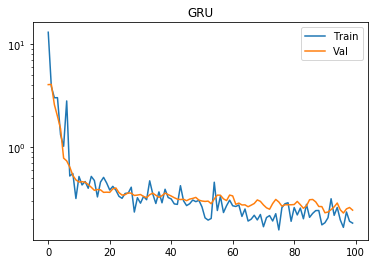

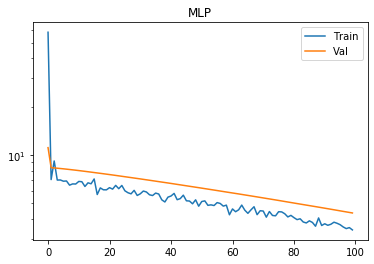

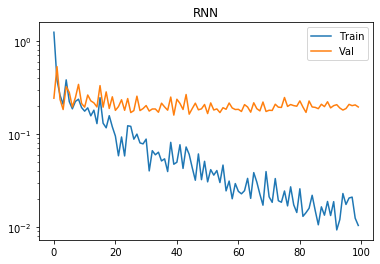

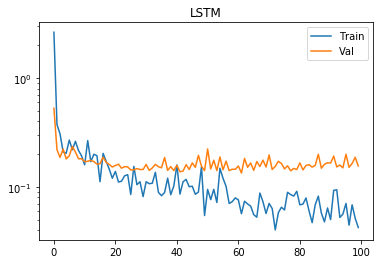

In [85]:
plot_history(gru_history,log=True,title="GRU")
plot_history(ff_history,log=True, title="MLP")
plot_history(rnn_history,log=True,title="RNN")
plot_history(lstm_history,log=True,title="LSTM")


In [86]:
# Evaluate the results on the test data. 
# Also evaluate the MSE of a naive approach which just predicts  the 
# rate in 3 months as the rate today. 
ff_eval = m_ff.evaluate_generator(test_gen, test_steps)
rnn_eval = m_rnn.evaluate_generator(test_gen, test_steps)
lstm_eval = m_lstm.evaluate_generator(test_gen, test_steps)
gru_eval = m_gru.evaluate_generator(test_gen, test_steps)

naive_eval = naive_prediction_gen(test_gen, test_steps)
pd.DataFrame({'MLP': ff_eval, 'SimpleRNN': rnn_eval, 'LSTM': lstm_eval, 'GRU': gru_eval, 'Naive': naive_eval}, index=['Test MSE'])

,MLP,SimpleRNN,LSTM,GRU,Naive
Test MSE,4.56546,0.191711,0.175555,0.227617,0.279668
